In [49]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle
import matplotlib.pyplot as plt
import copy

In [50]:
dir_name='reparse'
seq_len=15
step=15
cv_split_name='cv_splits_10'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
doc_indices
test_doc_num=8
seed=42

In [51]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
ens_crf_db_name   = 'ensemble_crf_cv_db_all'
ens_lg_db_name = 'ensemble_lg_cv_db_all'
cv_crf_bert_name = 'cv_crf_bert_all'
per_par=True
seq_len=3
step=3

### Open BERT predictions

In [52]:
i=0
splits_bert={}
for i in range(10):
    json_name="split_{}_bert_valid_dict".format(i)
    splits_bert[i]=common_utils.load_json(dir_name,json_name)

Opened /pathOpened /pathOpened /pathOpened /pathOpened /pathOpened /pathOpened /pathOpened /pathOpened /pathOpened /path

In [53]:
data=splits_bert[i]['valid_loss']

In [60]:
data

[0.5968185998499393,
 0.589226309210062,
 0.5857606902718544,
 0.5967651531100273,
 0.6128034107387066,
 0.6393431201577187,
 0.6656076908111572,
 0.7121210470795631,
 0.7652741149067879,
 0.831647977232933]

In [69]:
bert_loss_df=pd.DataFrame()
for k,v in splits_bert.items():
#     print(k,v['valid_loss'])
    bert_loss_df[k]=v['valid_loss']
common_utils.save_db(bert_loss_df,dir_name,"bert.loss.per.fold",False)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/bert.loss.per.fold.csv,  index False


In [57]:
splits_bert[y]['valid_loss']

[0.5968185998499393,
 0.589226309210062,
 0.5857606902718544,
 0.5967651531100273,
 0.6128034107387066,
 0.6393431201577187,
 0.6656076908111572,
 0.7121210470795631,
 0.7652741149067879,
 0.831647977232933]

In [55]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(splits_bert.keys())))

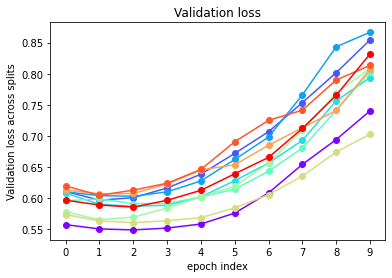

In [56]:
for y, c in zip(splits_bert.keys(), colors):
    data=splits_bert[y]['valid_loss']
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
# plt.legend()
plt.ylabel('Validation loss across splits') #set the label for y axis
plt.xlabel('epoch index') #set the label for x-axis
plt.title('Validation loss') #set the title of the graph
plt.show() #display the graph

### Check stories

In [11]:
imp.reload(classes)
reloaded_dataset=pickle.load( open( os.path.join(os.getcwd(), defines.PATH_TO_DFS, dir_name,"dataset_full.p"), "rb" ) )

In [12]:
nar_db=reloaded_dataset.get_nar_df()

In [58]:
nar_db.rename({0:'text'},axis=1,inplace=True)
nar_db

,text,doc_idx,len
1.0,אנחנו עכשיו בחברה בגלל שיש את כל הצמצומים אז ח...,1,653
2.0,ומתחתיי יש את אחי הצעיר. בהפרש יחסית יותר גדול...,1,653
3.0,והשלישית זה האמת שרוב הילדות הייתי מציק לה זה ...,1,653
4.0,נאי זוכר סתם איזו סיטואציה שישבנו מול הטלוויז...,1,653
5.0,בעבר לא הרגשתי את זה ככה. וכשהגעתי לישיבה אז ה...,1,653
...,...,...,...
13.0,היה סיפור בתחילת ה סוף ה בסתיו נכון עם הבגדים...,79,653
1.0,אני זוכר לפני לא זוכר מתי זה היה לפני שלושה ש...,80,653
2.0,פעם יותר שיתפתי את אה אמא שלי. אמ היום – היום...,80,653
3.0,גם הסופש הזה נגיד אני חושב זה בין הפעמים היחיד...,80,653


In [60]:
nar_db['len']=nar_db['text'].apply(lambda x: len(x))
nar_db

,text,doc_idx,len
1.0,אנחנו עכשיו בחברה בגלל שיש את כל הצמצומים אז ח...,1,2078
2.0,ומתחתיי יש את אחי הצעיר. בהפרש יחסית יותר גדול...,1,1093
3.0,והשלישית זה האמת שרוב הילדות הייתי מציק לה זה ...,1,860
4.0,נאי זוכר סתם איזו סיטואציה שישבנו מול הטלוויז...,1,649
5.0,בעבר לא הרגשתי את זה ככה. וכשהגעתי לישיבה אז ה...,1,1206
...,...,...,...
13.0,היה סיפור בתחילת ה סוף ה בסתיו נכון עם הבגדים...,79,303
1.0,אני זוכר לפני לא זוכר מתי זה היה לפני שלושה ש...,80,776
2.0,פעם יותר שיתפתי את אה אמא שלי. אמ היום – היום...,80,1231
3.0,גם הסופש הזה נגיד אני חושב זה בין הפעמים היחיד...,80,1764


In [81]:
with pd.option_context('display.max_colwidth', None):
    display(nar_db[nar_db['text'].str.contains("טלו")])

text  \
4.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [74]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None): 
    display(nar_db.query('len<300'))

,text,doc_idx,len
8.0,אז בפגישה הקודמת היציאה אחכ חזרתי אחכ לעבודה זה היה באמצע היום. נכון. חזרתי אחכ לעבודה והרגשתי היה לי נורא קשה לתפקד כאילו הרגשתי כאילו יש את החזית הזאת ויש גם את החזית הזאת כאילו מתקיפים אותי מכל החזיתות ואני צריך בעצם להתמודד עם הכל.,1,237
4.0,היא הייתה מבוגרת ממני. היא הייתה כשהכרתי אותה היא הייתה בת 123 . הכרנו ממש במקרה דרך איזה שהיא קבוצה.,2,103
1.0,כי גם הוא התקשר בבוקר ולא עניתי לו. כאילו דיברנו בסקייפ אבל אחר כך גם מישהי מהצוות שלי כתבה לי.,3,96
2.0,גם אם לא יהיה שום שינוי בעבודה למרות שאתמול דיברתי דווקא עם אחד. כאילו הוא מהצוות של הנגן אצלנו בעבודה. שלצוות הזה הייתי רוצה להיכנס אז הוא אמר לי שהם דיברו על זה שהם רוצים שאני אהיה מעורב גם כן וכבר בשבוע הבא הם מתחילים.,3,224
7.0,בהתחלה לא הבנתי כאילו ידעתי מה אני. חווה לא ידעתי מה המשמעות מה עומד מאחורי הדברים. ו עם הזמן דברים פתאום נהיו לי ברורים יותר.,3,131
8.0,והרגשתי שאנחנו חברים טובים והכל. ובאיזה שהוא שלב הוא הפך להיות הבוס שלי. ברגע שהוא נהיה הבוס שלי. משהו ביחסים שלנו השתנה. אני משהו עוצר אותי וזה לכל הדרגים שמעליי. משהו עוצר מבלהיפתח אליהם ברמה של חברות או צחוקים כמו שאני צוחק עם חברים או להגחיך את עצמי לידם כמו שאני מגחיך את עצמי ליד חברים.,3,295
4.0,אז כאילו כן עשיתי את זה ב באיזה אופן שפניתי ל מנהל הישיר שלי. ולא לאר אמ וועשיתי את זה גם בידיעה באמת של איזה פחד מלהתמודד ישירות. מול הבנאדם שחתמתי מול. כן כאילו כן יש לי פחד ליזום להתמודד עם זה אה ישירות. כאילו ללכת ישירות לאר או כאילו. כן.,4,248
2.0,אז היו כמה דברים שעשיתי אחד זה כתבתי את ההודעה הזאת לאי החבר ש. לא ראיתי מלא 123 שנים. אממ זה כאיל ומדהים אותי כל פעם מחדש אנשים מאוד שמחים שאני פונה כאילו מאוד שמחים לחדש איתי תקשר הוא ישר כאילו ענה לי מידית כזה היי מה נשמע XXX .,5,235
5.0,ויש עוד הצעה אחת שהיא כרגע פתוחה שדווקא זה תפקיד שאני כן רוצה אותו . מה שאמרתי לך כן תחום שמתעסק בתוספי מזון XXX ועוד תירגמתי את הקורות חיים שלי לאנגלית אז 123 שעות ישבתי XXX .,5,183
8.0,אני עוזב תעבודה הרי XXX לא יודע.,5,35


In [82]:
sent_db

NameError: name 'sent_db' is not defined

### Check document statistic

In [13]:
par_contain_nar=[]
for key,val in reloaded_dataset.doc_map.items():
    for par in var.par_list:
        if par.y == 'is_nar'
            
vars(reloaded_dataset.doc_map[1].par_list[0])

SyntaxError: invalid syntax (<ipython-input-13-40f13e66fc1e>, line 4)

In [92]:
par_len=[]
sent_len=[]
for key,val in reloaded_dataset.doc_map.items():
    par_len.append(len(val.par_list))
    sent_len.append(len(val.sent_list))

In [94]:
np.average(par_len),np.average(sent_len)

(186.55, 484.7625)

In [95]:
np.std(par_len),np.std(sent_len)

(109.89050231935424, 191.84272489138073)

In [96]:
np.median(par_len),np.median(sent_len)

(153.0, 470.0)

In [ ]:
for key,val in reloaded_dataset.doc_map.items():
    par_len.append(len(val.par_list))
    sent_len.append(len(val.sent_list))

In [102]:
vars(reloaded_dataset.doc_map[1].sent_list[13])

{'doc_idx': 1,
 'sent_idx': 13,
 'doc_len': 613,
 'par_idx': 10,
 'x': {'is_question': 0.0,
  'par_pos_in_doc': 0.0536585365853658,
  'sent_len': 0.0042168674698795,
  'is_client': 0.0,
  'sent_pos_in_par': 1.0,
  'sent_pos_in_doc': 0.0228384991843393,
  'TOKEN': 0.006060606060606,
  'POSTAG_DEF': 0.5,
  'POSTAG_NN': 0.5,
  'POSTAG_PREPOSITION': 0.5,
  'POSTAG_PRP': 0.5,
  'f_gen_M': 1.0,
  'f_num_S': 1.0,
  'f_per_3': 0.5,
  '-1:is_question': 0.5,
  '-1:par_pos_in_doc': 0.0536585365853658,
  '-1:sent_len': 0.0156626506024096,
  '-1:is_client': 0.0,
  '-1:sent_pos_in_par': 0.5,
  '-1:sent_pos_in_doc': 0.0212071778140293,
  '-1:TOKEN': 0.0363636363636363,
  '-1:POSTAG_DEF': 0.1428571428571428,
  '-1:POSTAG_IN': 0.1428571428571428,
  '-1:POSTAG_MD': 0.1428571428571428,
  '-1:POSTAG_NN': 0.1428571428571428,
  '-1:POSTAG_NNT': 0.1428571428571428,
  '-1:POSTAG_PREPOSITION': 0.1428571428571428,
  '-1:POSTAG_PRP': 0.2857142857142857,
  '-1:POSTAG_RB': 0.1428571428571428,
  '-1:f_gen_M': 0.714

### Check paragraph statistic

In [14]:
reloaded_dataset.doc_map[1].par_list

{0: <classes.Paragraph at 0x2b96c4b4cc40>,
 1: <classes.Paragraph at 0x2b96c4b4cc70>,
 2: <classes.Paragraph at 0x2b96c4b4cca0>,
 3: <classes.Paragraph at 0x2b96c4b4ccd0>,
 4: <classes.Paragraph at 0x2b96c4b4cd00>,
 5: <classes.Paragraph at 0x2b96c4b4cd30>,
 6: <classes.Paragraph at 0x2b96c4b4cd60>,
 7: <classes.Paragraph at 0x2b96c4b4cd90>,
 8: <classes.Paragraph at 0x2b96c4b4cdf0>,
 9: <classes.Paragraph at 0x2b96c4b4ce20>,
 10: <classes.Paragraph at 0x2b96c4b4ce80>,
 11: <classes.Paragraph at 0x2b96c4b4cee0>,
 12: <classes.Paragraph at 0x2b96c4b4cf40>,
 13: <classes.Paragraph at 0x2b96c4b4cf70>,
 14: <classes.Paragraph at 0x2b96c4b4cfd0>,
 15: <classes.Paragraph at 0x2b96c586c040>,
 16: <classes.Paragraph at 0x2b96c586c070>,
 17: <classes.Paragraph at 0x2b96c586c0a0>,
 18: <classes.Paragraph at 0x2b96c586c0d0>,
 19: <classes.Paragraph at 0x2b96c586c100>,
 20: <classes.Paragraph at 0x2b96c586c130>,
 21: <classes.Paragraph at 0x2b96c586c160>,
 22: <classes.Paragraph at 0x2b96c586c1c0>

In [15]:
imp.reload(classes)
new_dataset=classes.Dataset(reloaded_dataset.path)

Dataset init called


In [21]:
for k,doc in reloaded_dataset.doc_map.items():
    new_dataset.doc_map[k]={}
    new_dataset.doc_map[k] = classes.Document(k,new_dataset.path)
    new_dataset.doc_map[k].__dict__ = doc.__dict__

In [22]:
new_dataset.doc_map[1]

In [23]:
new_dataset.pack_sent_per_paragraph()

In [136]:
par_stat_db=pd.DataFrame()

for k,doc in new_dataset.doc_map.items():
    for j,par in doc.par_map.items():
        par_stat_db.iloc[k,'doc_idx']=k
        

5 4 0.8
1 1 1.0
1 1 1.0
1 1 1.0
1 1 1.0
1 1 1.0
2 2 1.0
1 1 1.0
15 15 1.0
1 1 1.0
3 3 1.0
1 1 1.0
1 1 1.0
3 3 1.0
1 1 1.0
1 1 1.0
5 5 1.0
5 2 0.4
1 1 1.0
5 5 1.0
1 1 1.0
2 2 1.0
1 1 1.0
2 2 1.0
1 1 1.0
9 9 1.0
13 4 0.3076923076923077
2 2 1.0
4 4 1.0
1 1 1.0
1 1 1.0
1 1 1.0
1 1 1.0
1 1 1.0
5 4 0.8
7 6 0.8571428571428571
2 2 1.0
3 3 1.0
8 8 1.0
5 5 1.0
58 57 0.9827586206896551
6 6 1.0
5 5 1.0
6 5 0.8333333333333334
8 1 0.125
1 1 1.0
1 1 1.0
10 8 0.8
27 24 0.8888888888888888
24 9 0.375
1 1 1.0
6 6 1.0
1 1 1.0
1 1 1.0
1 1 1.0
1 1 1.0
2 2 1.0
1 1 1.0
2 2 1.0
2 2 1.0
3 3 1.0
8 8 1.0


### Inspect BERT performance

In [41]:
cv_db_bert=common_utils.load_db(dir_name,"cv_bert_all")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_bert_all.csv,  index False


Split 0
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2597
           1       0.50      0.56      0.53       781

    accuracy                           0.77      3378
   macro avg       0.68      0.70      0.69      3378
weighted avg       0.78      0.77      0.77      3378

MySegEval init called
Split 1
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      2911
           1       0.47      0.59      0.52      1045

    accuracy                           0.72      3956
   macro avg       0.65      0.68      0.66      3956
weighted avg       0.74      0.72      0.73      3956

MySegEval init called
Split 2
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      2498
           1       0.54      0.55      0.55       915

    accuracy                           0.76      3413
   macro avg       0.69      0.69      0.69      3413
weight

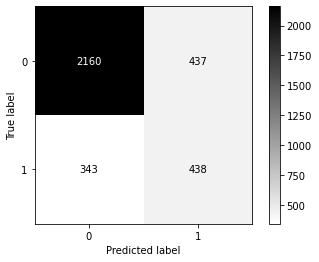

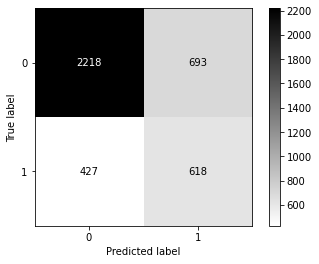

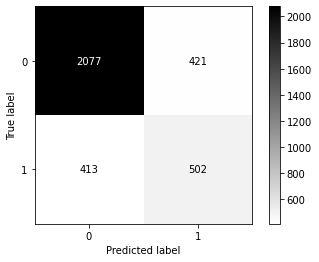

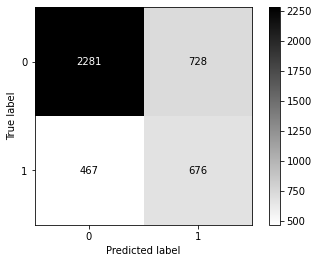

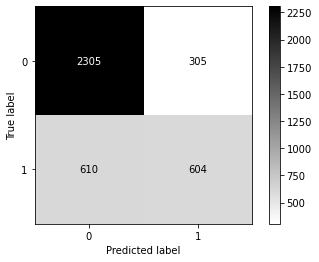

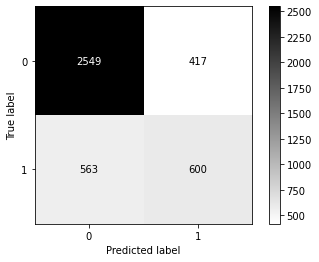

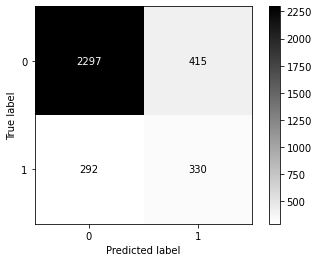

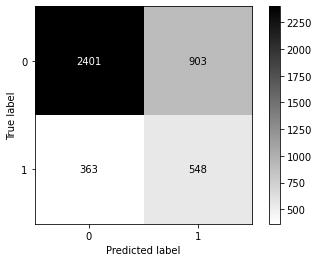

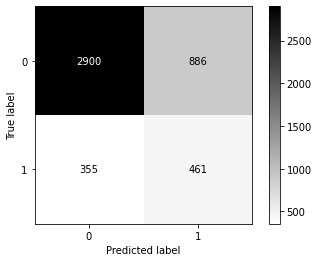

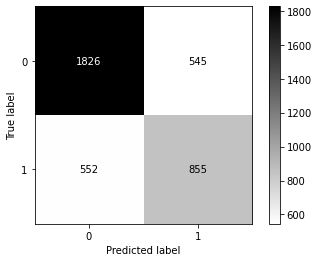

In [42]:
bert_scores, bert_dict = model_utils.get_report_from_splits(cv_db_bert,"bert")

In [43]:
bert_dict

{0: {'0': {'precision': 0.8629644426687975,
   'recall': 0.8317289179822872,
   'f1-score': 0.8470588235294118,
   'support': 2597},
  '1': {'precision': 0.5005714285714286,
   'recall': 0.5608194622279129,
   'f1-score': 0.5289855072463768,
   'support': 781},
  'accuracy': 0.7690941385435168,
  'macro avg': {'precision': 0.681767935620113,
   'recall': 0.6962741901051,
   'f1-score': 0.6880221653878943,
   'support': 3378},
  'weighted avg': {'precision': 0.7791784912152614,
   'recall': 0.7690941385435168,
   'f1-score': 0.7735196701791898,
   'support': 3378},
  'segeval': {'f1': Decimal('0.1942307692307692307692307693'),
   'recall': Decimal('0.1075612353567625133120340788'),
   'precision': Decimal('0.1075612353567625133120340788'),
   'b_sim': Decimal('0.1052083333333333333333333333'),
   's_sim': Decimal('0.7456322179449215279834172342')}},
 1: {'0': {'precision': 0.8385633270321361,
   'recall': 0.7619374785297148,
   'f1-score': 0.7984161267098633,
   'support': 2911},
  '1':

In [44]:
colors=['r','b']
linestyle=['dashed','solid']
f1={}
f1['1']=[]
f1['0']=[]
for label in f1.keys():
    for key,val in bert_dict.items():
        f1[label].append(val[label]['f1-score'])

In [45]:
avg={}
avg['1']={}
avg['0']={}
avg['weighted avg']={}
for label in avg.keys():
    avg[label]={}
    avg[label]['recall']=[]
    avg[label]['prec']=[]
    avg[label]['f1']=[]

    for key,val in bert_dict.items():
        avg[label]['f1'].append(val[label]['f1-score'])
        avg[label]['recall'].append(val[label]['recall'])
        avg[label]['prec'].append(val[label]['precision'])

In [46]:
for label,metrics in avg.items():
    for metric,value in metrics.items():
        print("{:>15} {:>10} {:.3f}".format(label,metric,np.mean(value)))
    

              1     recall 0.561
              1       prec 0.503
              1         f1 0.523
              0     recall 0.804
              0       prec 0.839
              0         f1 0.819
   weighted avg     recall 0.740
   weighted avg       prec 0.759
   weighted avg         f1 0.746


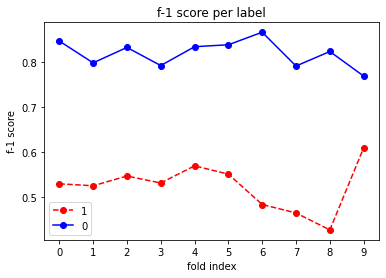

In [47]:
from matplotlib import pyplot as plt
for y, c, st in zip(f1.keys(), colors,linestyle):
    data=f1[y]
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c,linestyle=st,label=y)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
plt.legend()
plt.ylabel('f-1 score') #set the label for y axis
plt.xlabel('fold index') #set the label for x-axis
plt.title('f-1 score per label') #set the title of the graph
plt.show() #display the graph

In [48]:
f1

{'1': [0.5289855072463768,
  0.5246179966044142,
  0.5462459194776931,
  0.5308205732233999,
  0.5690061234102685,
  0.5504587155963302,
  0.48280907095830283,
  0.46401354784081283,
  0.42625982431807674,
  0.6091913074456716],
 '0': [0.8470588235294118,
  0.7984161267098633,
  0.8327987169206095,
  0.7924266110821608,
  0.8343891402714932,
  0.838762750904903,
  0.8666289379362385,
  0.7913645352669744,
  0.823746626899588,
  0.7690040008422827]}

In [51]:
imp.reload(classes)
rprt=classes.MyReport()
avg=rprt.get_avg_scores(bert_dict,labels=['0','1'])
for l in ['0','1']:
    print("{} {}".format(l,avg[l]['avg']))

MyReport init called
0 {'recall': 0.8035529519451459, 'prec': 0.8390240426638066, 'f1': 0.8194596270363526}
1 {'recall': 0.5610413223734291, 'prec': 0.5025344292904043, 'f1': 0.5232408586121347}


In [52]:
avg

{'0': {'recall': [0.8317289179822872,
   0.7619374785297148,
   0.8314651721377102,
   0.7580591558657361,
   0.8831417624521073,
   0.8594066082265678,
   0.846976401179941,
   0.7266949152542372,
   0.7659799260433174,
   0.7701391817798398],
  'prec': [0.8629644426687975,
   0.8385633270321361,
   0.834136546184739,
   0.8300582241630277,
   0.79073756432247,
   0.8190874035989717,
   0.8872151409810738,
   0.8686685962373372,
   0.890937019969278,
   0.7678721614802355],
  'f1': [0.8470588235294118,
   0.7984161267098633,
   0.8327987169206095,
   0.7924266110821608,
   0.8343891402714932,
   0.838762750904903,
   0.8666289379362385,
   0.7913645352669744,
   0.823746626899588,
   0.7690040008422827],
  'avg': {'recall': 0.8035529519451459,
   'prec': 0.8390240426638066,
   'f1': 0.8194596270363526}},
 '1': {'recall': [0.5608194622279129,
   0.5913875598086125,
   0.5486338797814208,
   0.5914260717410323,
   0.4975288303130148,
   0.5159071367153912,
   0.5305466237942122,
   0.60

In [54]:
np.argmin(avg['1']['f1']),np.min(avg['1']['f1'])

(8, 0.42625982431807674)

In [55]:
np.argmax(avg['1']['f1']),np.max(avg['1']['f1'])

(9, 0.6091913074456716)

In [58]:
(np.max(avg['1']['f1'])-np.min(avg['1']['f1']))/np.min(avg['1']['f1'])

0.42915487853035544

In [56]:
np.std(avg['1']['f1']),np.std(avg['0']['f1'])

(0.05039073134850432, 0.028787475462185165)

In [26]:
colors=['r','b']
linestyle=['dashed','solid']
f1={}
f1['1']=[]
f1['0']=[]
for label in f1.keys():
    for key,val in bert_dict.items():
        f1[label].append(val[label]['f1-score'])

NameError: name 'bert_dict' is not defined

In [25]:
from matplotlib import pyplot as plt
for y, c, st in zip(f1.keys(), colors,linestyle):
    data=f1[y]
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c,linestyle=st,label=y)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
plt.legend()
plt.ylabel('f-1 score') #set the label for y axis
plt.xlabel('fold index') #set the label for x-axis
plt.title('f-1 score per label') #set the title of the graph
plt.show() #display the graph

NameError: name 'f1' is not defined

### Inspect CRF performance

In [27]:
cv_db_crf=common_utils.load_db(dir_name,"cv_crf_best_params.78")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_crf_best_params.78.csv,  index False


In [28]:
cv_db_crf

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1
0,4,0,not_nar,not_nar,0.945664,0.054336
1,4,0,not_nar,not_nar,0.961845,0.038155
2,4,0,not_nar,not_nar,0.972418,0.027582
3,4,0,not_nar,not_nar,0.898435,0.101565
4,4,0,not_nar,not_nar,0.797448,0.202552
...,...,...,...,...,...,...
38776,79,9,not_nar,not_nar,0.969682,0.030318
38777,79,9,not_nar,not_nar,0.958210,0.041790
38778,79,9,not_nar,not_nar,0.976662,0.023338
38779,79,9,not_nar,not_nar,0.978750,0.021250


Split 0
              precision    recall  f1-score   support

      is_nar       0.64      0.53      0.58       781
     not_nar       0.87      0.91      0.89      2597

    accuracy                           0.82      3378
   macro avg       0.75      0.72      0.73      3378
weighted avg       0.81      0.82      0.82      3378

MySegEval init called
Split 1
              precision    recall  f1-score   support

      is_nar       0.62      0.42      0.50      1045
     not_nar       0.81      0.91      0.86      2911

    accuracy                           0.78      3956
   macro avg       0.72      0.66      0.68      3956
weighted avg       0.76      0.78      0.76      3956

MySegEval init called
Split 2
              precision    recall  f1-score   support

      is_nar       0.55      0.46      0.50       915
     not_nar       0.81      0.86      0.84      2498

    accuracy                           0.75      3413
   macro avg       0.68      0.66      0.67      3413
weight

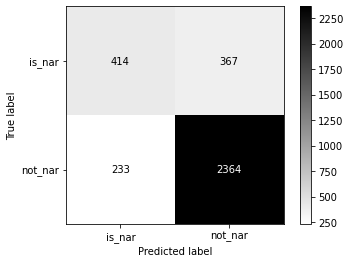

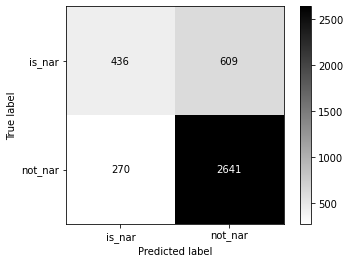

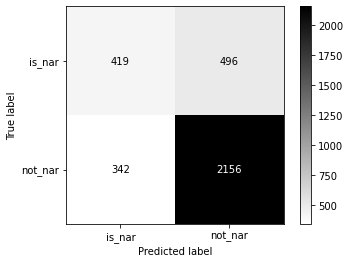

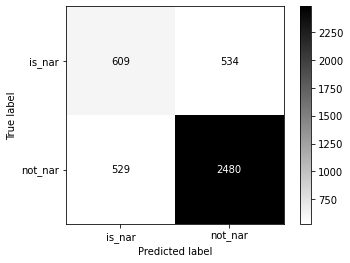

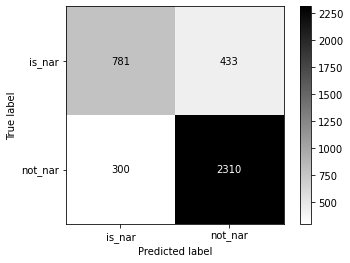

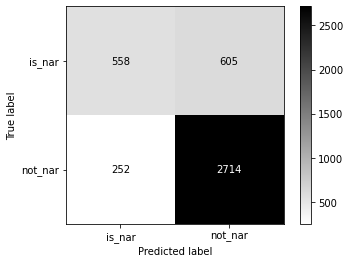

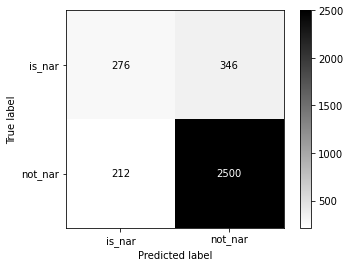

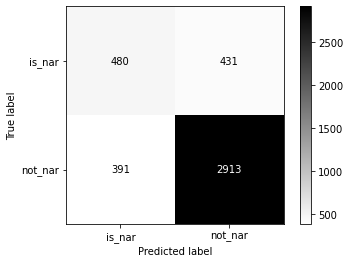

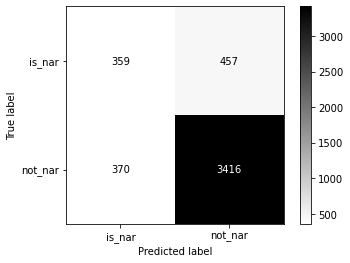

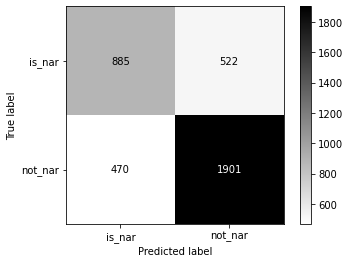

In [29]:
crf_scores, crf_dict = model_utils.get_report_from_splits(cv_db_crf,"crf")

In [30]:
imp.reload(classes)
rprt=classes.MyReport()
labels=['not_nar','is_nar','weighted avg']
avg=rprt.get_avg_scores(crf_dict,labels=labels)
for l in labels:
    print("\n{:>15}".format(l),end =' ')
    for k,v in avg[l]['avg'].items():
#         print(k)
        print("{:>8} {:>8.3f}".format(k,v),end=' ')

MyReport init called

        not_nar   recall    0.881     prec    0.839       f1    0.859 
         is_nar   recall    0.510     prec    0.602       f1    0.550 
   weighted avg   recall    0.789     prec    0.782       f1    0.783 

In [81]:
imp.reload(common_utils)
crf_best_params=common_utils.load_pickle("","crf.rs.params.793")
crf_best_params

{'min_freq': 5, 'c2': 0.0071, 'c1': 0.459, 'algorithm': 'lbfgs'}

In [77]:
avg['weighted avg']

{'recall': [0.822380106571936,
  0.7778058645096056,
  0.754468209786112,
  0.7439788053949904,
  0.80831589958159,
  0.7924436909663357,
  0.8326334733053389,
  0.804982206405694,
  0.8202955236853542,
  0.737427210164108],
 'prec': [0.8134253269821815,
  0.7610913782265192,
  0.7426292052921076,
  0.7436323730451078,
  0.8041539298716112,
  0.7814298780307108,
  0.8200593341004851,
  0.8019452266681191,
  0.8129311835971929,
  0.7356182480107704],
 'f1': [0.816279983582251,
  0.7624100195393985,
  0.7468588691439642,
  0.7438044716084867,
  0.8051429345625822,
  0.7797049345402934,
  0.824548722030586,
  0.8033801506434487,
  0.8162565313104408,
  0.7363795388176981],
 'avg': {'recall': 0.7894730990371065,
  'prec': 0.7816916083824806,
  'f1': 0.7834766155779149}}

In [35]:
crf_dict

{0: {'is_nar': {'precision': 0.6398763523956723,
   'recall': 0.5300896286811779,
   'f1-score': 0.5798319327731092,
   'support': 781},
  'not_nar': {'precision': 0.8656169901135116,
   'recall': 0.9102810935695033,
   'f1-score': 0.8873873873873874,
   'support': 2597},
  'accuracy': 0.822380106571936,
  'macro avg': {'precision': 0.7527466712545919,
   'recall': 0.7201853611253406,
   'f1-score': 0.7336096600802483,
   'support': 3378},
  'weighted avg': {'precision': 0.8134253269821815,
   'recall': 0.822380106571936,
   'f1-score': 0.816279983582251,
   'support': 3378},
  'segeval': {'f1': Decimal('0.1693989071038251366120218579'),
   'recall': Decimal('0.09253731343283582089552238806'),
   'precision': Decimal('0.09253731343283582089552238806'),
   'b_sim': Decimal('0.08857142857142857142857142857'),
   's_sim': Decimal('0.9527687296416938110749185668')}},
 1: {'is_nar': {'precision': 0.6175637393767706,
   'recall': 0.4172248803827751,
   'f1-score': 0.4980011422044545,
   'sup

In [82]:
np.argmin(avg[labels[1]]['f1']),np.min(avg[labels[1]]['f1'])

(8, 0.4647249190938511)

In [83]:
np.argmax(avg[labels[1]]['f1']),np.max(avg[labels[1]]['f1'])

(4, 0.6806100217864924)

In [33]:
colors=['r','b']
linestyle=['dashed','solid']
f1_crf={}
f1_crf['is_nar']=[]
f1_crf['not_nar']=[]
for label in f1_crf.keys():
    for key,val in crf_dict.items():
        f1_crf[label].append(val[label]['f1-score'])

In [38]:
f1_crf

{'is_nar': [0.5798319327731092,
  0.4980011422044545,
  0.5,
  0.5339763261727313,
  0.6806100217864924,
  0.565636087176888,
  0.4972972972972972,
  0.5387205387205387,
  0.4647249190938511,
  0.6408399710354815],
 'not_nar': [0.8873873873873874,
  0.8573283557863982,
  0.8372815533980583,
  0.8235098787979412,
  0.8630674388193535,
  0.8636435958631662,
  0.8996041741633682,
  0.8763537906137184,
  0.8920224572398484,
  0.7930746766791823]}

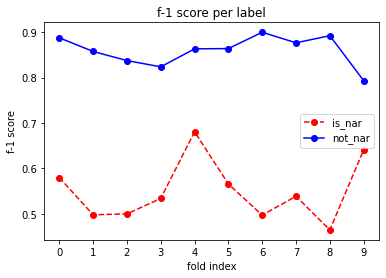

In [37]:
from matplotlib import pyplot as plt
for y, c, st in zip(f1_crf.keys(), colors,linestyle):
    data=f1_crf[y]
    min_x = np.argmin(data)
    min_y = np.min(data)
    plt.plot(data,marker='o',color=c,linestyle=st,label=y)#, color='magenta', marker='o',mfc='pink' ) #plot the data
#     plt.scatter(min_x, min_y,c='r', label='minimum',zorder =1)
plt.xticks(range(0,len(data), 1)) #set the tick frequency on x-axis
plt.legend()
plt.ylabel('f-1 score') #set the label for y axis
plt.xlabel('fold index') #set the label for x-axis
plt.title('f-1 score per label') #set the title of the graph
plt.show() #display the graph

In [114]:
ensemble_cv_db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,0,0.890436,0.109564,4,0,0
1,0,0.916622,0.083378,4,0,0
2,0,0.926823,0.073177,4,0,0
3,0,0.866444,0.133556,4,0,0
4,0,0.832372,0.167628,4,0,0
...,...,...,...,...,...,...
38776,0,0.923250,0.076750,79,9,0
38777,0,0.934124,0.065876,79,9,0
38778,0,0.937986,0.062014,79,9,0
38779,0,0.937129,0.062871,79,9,0


### Load original splits

In [100]:
cv_splits_loaded=common_utils.load_json(dir_name,"cv_splits_10")
cv_splits_loaded

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/cv_splits_10.json


{'0': {'test': [4, 14, 15, 18, 29, 32, 36, 70],
  'train': [1,
   2,
   3,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   16,
   17,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   30,
   31,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80]},
 '1': {'test': [5, 6, 13, 34, 37, 62, 73, 80],
  'train': [1,
   2,
   3,
   4,
   7,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   35,
   36,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   6

In [104]:
for k,v in cv_splits_loaded.items():
    if (4 in v['test'] and 76 in v['test']):
        print ('both in test',k)
    if (4 in v['train'] and 76 in v['train']):
        print ('both in train',k)

both in train 1
both in train 2
both in train 3
both in train 5
both in train 6
both in train 7
both in train 8
both in train 9


### Merge new CRF and old BERT

In [90]:
cv_db_crf=cv_db_crf.assign(sent_idx=cv_db_crf.groupby(['crf_group']).cumcount())
cv_db_bert=cv_db_bert.assign(sent_idx=cv_db_bert.groupby(['bert_group']).cumcount())

In [95]:
merged_cv_db=pd.merge(cv_db_crf,cv_db_bert,left_on=['crf_group','sent_idx'],right_on=['bert_group','sent_idx'],validate='one_to_one')


In [84]:
cv_db_crf

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1
0,4,0,not_nar,not_nar,0.945664,0.054336
1,4,0,not_nar,not_nar,0.961845,0.038155
2,4,0,not_nar,not_nar,0.972418,0.027582
3,4,0,not_nar,not_nar,0.898435,0.101565
4,4,0,not_nar,not_nar,0.797448,0.202552
...,...,...,...,...,...,...
38776,79,9,not_nar,not_nar,0.969682,0.030318
38777,79,9,not_nar,not_nar,0.958210,0.041790
38778,79,9,not_nar,not_nar,0.976662,0.023338
38779,79,9,not_nar,not_nar,0.978750,0.021250


In [106]:
ensemble_res=pd.DataFrame()
ensemble_cv_db=model_utils.prepared_cross_validate_ensemble(LogisticRegression(random_state=0),ensemble_res,merged_cv_db,cv_splits_loaded)

0 split started...
train: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
test: [4, 14, 15, 18, 29, 32, 36, 70]
1 split started...
train: [1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79]
test: [5, 6, 13, 34, 37, 62, 73, 80]
2 split started...
train: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 55, 56, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]
tes

In [89]:
cv_db_crfx

,crf_group,crf_split,crf_predicted,crf_true,crf_proba_0,crf_proba_1
0,4,0,not_nar,not_nar,0.945664,0.054336
1,4,0,not_nar,not_nar,0.961845,0.038155
2,4,0,not_nar,not_nar,0.972418,0.027582
3,4,0,not_nar,not_nar,0.898435,0.101565
4,4,0,not_nar,not_nar,0.797448,0.202552
...,...,...,...,...,...,...
38776,79,9,not_nar,not_nar,0.969682,0.030318
38777,79,9,not_nar,not_nar,0.958210,0.041790
38778,79,9,not_nar,not_nar,0.976662,0.023338
38779,79,9,not_nar,not_nar,0.978750,0.021250


Split 0
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      2597
           1       0.75      0.50      0.60       781

    accuracy                           0.84      3378
   macro avg       0.80      0.72      0.75      3378
weighted avg       0.84      0.84      0.83      3378

Split 1
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2911
           1       0.67      0.39      0.49      1045

    accuracy                           0.79      3956
   macro avg       0.74      0.66      0.68      3956
weighted avg       0.77      0.79      0.77      3956

Split 2
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      2498
           1       0.68      0.42      0.51       915

    accuracy                           0.79      3413
   macro avg       0.74      0.67      0.69      3413
weighted avg       0.78      0.79      0.77      3

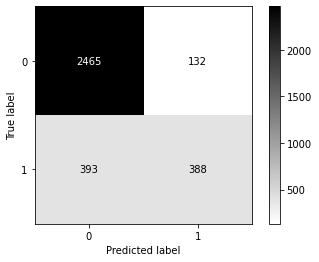

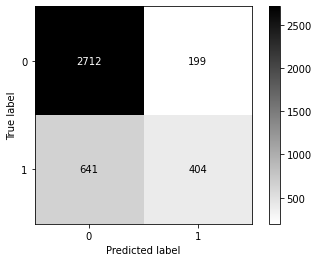

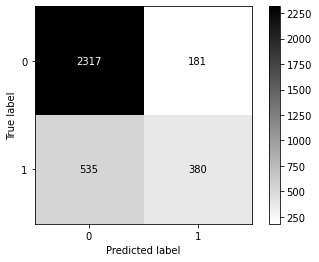

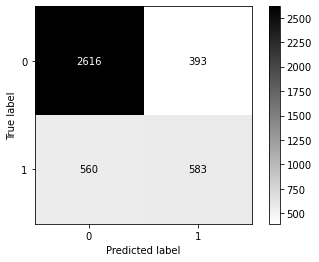

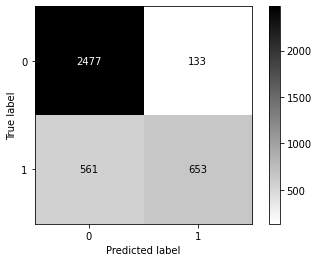

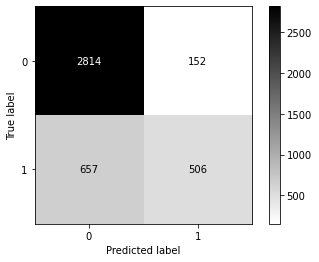

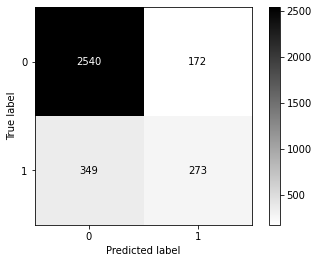

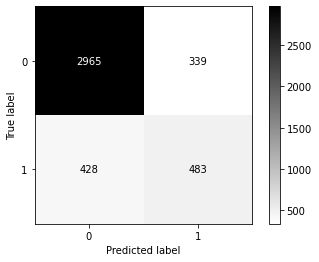

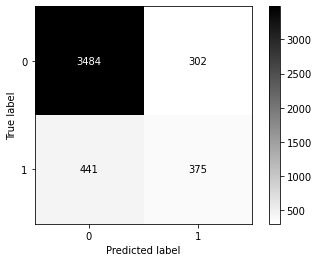

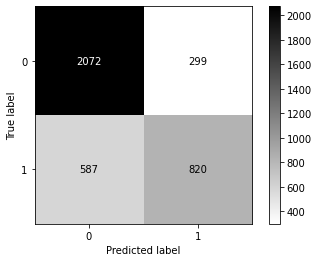

In [109]:
ens_scores, ens_dict = model_utils.get_report_from_splits(ensemble_cv_db,"ens")

In [94]:
xxens_scores, ens_dict = model_utils.get_report_from_splits(merged_cv_db,"ens")

KeyError: 'ens_predicted'

In [118]:
imp.reload(classes)
rprt=classes.MyReport()
labels=['0','1']
labels.append('weighted avg')
avg=rprt.get_avg_scores(ens_dict,labels=labels)
for l in labels:
    print("\n{:>15}".format(l),end =' ')
    for k,v in avg[l]['avg'].items():
#         print(k)
        print("{:>8} {:>8.3f}".format(k,v),end=' ')

MyReport init called

              0   recall    0.920     prec    0.835       f1    0.875 
              1   recall    0.479     prec    0.678       f1    0.558 
   weighted avg   recall    0.808     prec    0.800       f1    0.797 

In [114]:
ensemble_cv_db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,0,0.890436,0.109564,4,0,0
1,0,0.916622,0.083378,4,0,0
2,0,0.926823,0.073177,4,0,0
3,0,0.866444,0.133556,4,0,0
4,0,0.832372,0.167628,4,0,0
...,...,...,...,...,...,...
38776,0,0.923250,0.076750,79,9,0
38777,0,0.934124,0.065876,79,9,0
38778,0,0.937986,0.062014,79,9,0
38779,0,0.937129,0.062871,79,9,0
